<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Practical_2_Active_Learning_DensitySampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Active Learning on MRI Brain Tumor Classification
brain-tumor-mri-dataset<br>
Dataset-1: Labelled Dataset<br>
Source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
Type of images = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
Total number of MRI slices = 5712<br>

Dataset-2: Unlabelled Dataset<br>
Source: https://www.kaggle.com/datasets/shreyag1103/brain-mri-scans-for-brain-tumor-classification <br>
Total number of MRI slices = 1311<br>

<img src="https://miro.medium.com/v2/resize:fit:1400/1*D_LnIlqZFdE2lPvMsj_U8Q.png" alt="Sample Image" width="400">

In [ ]:
!gdown 1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1
!unzip -q braintumor.zip

Downloading...
From (original): https://drive.google.com/uc?id=1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1
From (redirected): https://drive.google.com/uc?id=1uLWrAYu3eBwzWmYJ6rrIryL7tW3v-Ib1&confirm=t&uuid=8147f71b-e192-4827-97fb-6590a29612fd
To: /content/braintumor.zip
100% 130M/130M [00:02<00:00, 46.4MB/s]


Dataset details:

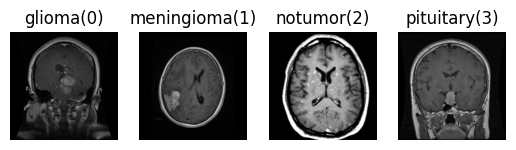

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Training/glioma/Tr-gl_0026.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Training/meningioma/Tr-meTr_0007.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Training/notumor/Tr-noTr_0003.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Training/pituitary/Tr-piTr_0002.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Dataloader

In [ ]:
import os
import sys
from torchvision import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import Counter

# Set a fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize,
]))

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Calculate lengths for each split
total_size = len(dataset_)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Perform the split
train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])

# Mapping of class indices to class names
class_to_idx = dataset_.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print split information
print(f"Total samples: {len(dataset_)}")
print(f"Training samples: {len(train_split)}")
print(f"Validation samples: {len(val_split)}")
print(f"Mapping of class: {idx_to_class}")

Total samples: 5712
Training samples: 4569
Validation samples: 1143
Mapping of class: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


#Evaluation on labelled dataset
The training process of ResNet model can be found here: https://github.com/mobarakol/AI_Medical_Imaging/blob/main/Active_Learning_Training_ReseNet.ipynb<br>

Download the pretrained weights:

In [ ]:
!gdown 1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU

Downloading...
From: https://drive.google.com/uc?id=1rs1N_PQ9ZWRjBSwbsFviOgvAP8cYeQNU
To: /content/best_model_4.pth.tar
100% 85.3M/85.3M [00:02<00:00, 42.3MB/s]


Evaluate the performance:

In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

def evaluate(model, valid_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 4
validloader = DataLoader(val_split, batch_size=128, shuffle=False, num_workers=2)

model = models.resnet34(weights=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model_4.pth.tar'))
accuracy = evaluate(model, validloader)
print('accuracy: {:.3f}%'.format(accuracy*100))

accuracy: 96.413%


#Active Learning on new dataset:

Download new dataset

In [ ]:
!gdown 1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
!unzip -q braintumor_v2.zip

Downloading...
From: https://drive.google.com/uc?id=1TdJk-0Gu4e9C-T1dN2t-U6glDKoEhFFt
To: /content/braintumor_v2.zip
100% 25.6M/25.6M [00:01<00:00, 17.3MB/s]


Visualizing new dataset:

total images: 1311


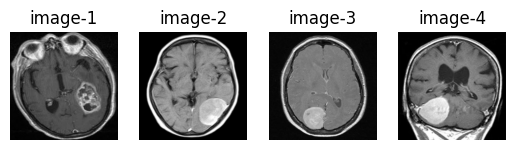

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
img_path_all = glob('braintumor_v2/*/*.jpg')
print('total images:', len(img_path_all))

class_names = ['image-1', 'image-2', 'image-3', 'image-4']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0001.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor_v2/meningioma/Te-meTr_0004.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor_v2/meningioma/Te-me_0010.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor_v2/meningioma/Te-me_0020.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

#Active Learning: Diversity Sampling
Visualizing image distribution with tSNE plot (embedding level)

sample size of new dataset: 1311
Total dimension after t-SNE reduction: (1311, 2)


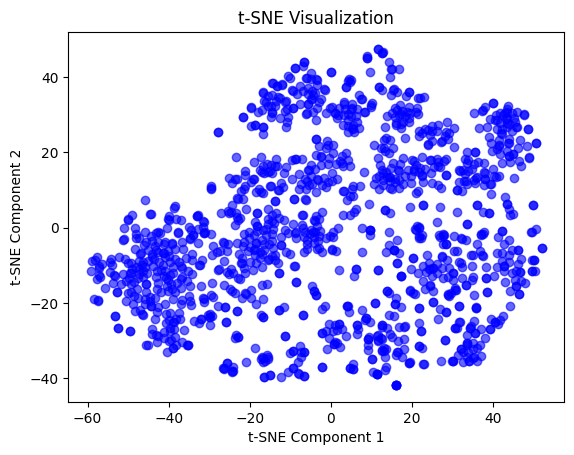

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        normalize,
]))

print('sample size of new dataset:', len(new_dataset))

img_all = []
for data, lab in new_dataset:
    img_all.append(np.array(data)[0,:,:])


img_all = np.array(img_all).reshape(len(new_dataset),28*28)

# Perform t-SNE dimensionality reduction
X_new_embedded = TSNE(n_components=2, random_state=42).fit_transform(img_all)

print('Total dimension after t-SNE reduction:', X_new_embedded.shape)


## Perform t-SNE for labeled trainset

# Plot without labels
fig, ax = plt.subplots()
ax.scatter(X_new_embedded[:, 0], X_new_embedded[:, 1], alpha=0.6, color='blue')  # Single color

ax.set_title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
plt.close()

## Visualize the labeld data feature in another plot with a different color

Total dimension after t-SNE reduction (train): (4569, 2)


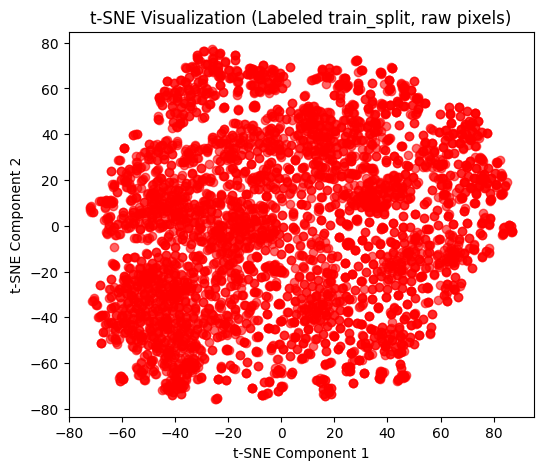

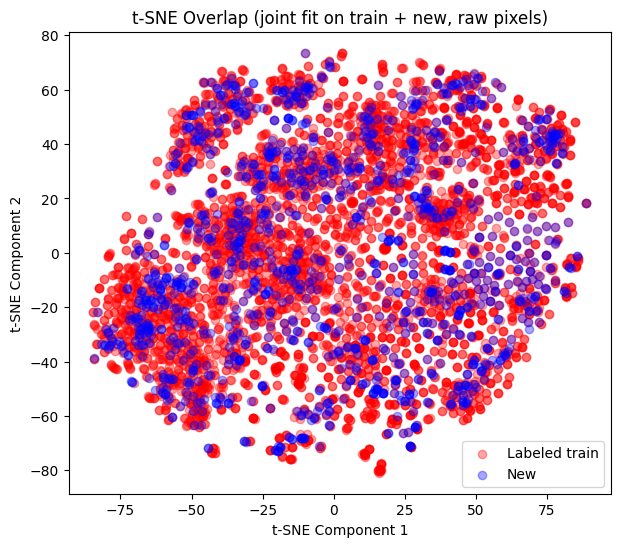

In [38]:
import torch.nn.functional as F
# ---------------------------
# Helper: turn image tensor into 28x28 grayscale flattened vector
# ---------------------------
def to_gray_28x28_flat(x):
    """
    x: torch.Tensor [C,H,W] (C=1 or 3)
    returns: np.array shape (784,)
    """
    if not torch.is_tensor(x):
        x = torch.tensor(x)
    x = x.float()

    # Convert to grayscale if RGB
    if x.ndim == 3 and x.shape[0] == 3:
        x = x.mean(dim=0, keepdim=True)  # [1,H,W]
    elif x.ndim == 2:
        x = x.unsqueeze(0)               # [1,H,W]
    elif x.ndim == 3 and x.shape[0] == 1:
        pass
    else:
        raise ValueError(f"Unexpected shape: {tuple(x.shape)}")

    # Resize to 28x28 if needed
    if x.shape[1] != 28 or x.shape[2] != 28:
        x = F.interpolate(x.unsqueeze(0), size=(28, 28), mode="bilinear", align_corners=False).squeeze(0)

    return x.view(-1).cpu().numpy().astype(np.float32)

# Extract raw features for train_split
X_train = []
y_train = []
for data, lab in train_split:
    X_train.append(to_gray_28x28_flat(data))
    y_train.append(lab)

X_train = np.stack(X_train, axis=0)  # (N_train, 784)
y_train = np.array(y_train)          # (N_train,)

# Important: If you want to compare/overlap with new dataset fairly,
# fit ONE joint t-SNE on (train + new) rather than separate fits.
# But since your prompt says "another plot", we do separate t-SNE here first:

X_train_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)
print('Total dimension after t-SNE reduction (train):', X_train_embedded.shape)

# Plot LABELED train dataset with a different color
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(X_train_embedded[:, 0], X_train_embedded[:, 1], alpha=0.6, color='red')
ax.set_title('t-SNE Visualization (Labeled train_split, raw pixels)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
plt.show()
plt.close()


X_all = np.concatenate([X_train, img_all], axis=0)
X_all_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_all)

X_train_joint = X_all_embedded[:len(X_train)]
X_new_joint = X_all_embedded[len(X_train):]

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(X_train_joint[:, 0], X_train_joint[:, 1], alpha=0.35, color='red', label='Labeled train')
ax.scatter(X_new_joint[:, 0], X_new_joint[:, 1], alpha=0.35, color='blue', label='New')
ax.set_title('t-SNE Overlap (joint fit on train + new, raw pixels)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.legend()
plt.show()
plt.close()

Selecting diverse samples: 131 out of 1311
Diverse indices selected: 131
Diversity score stats (dist to nearest labeled): mean=1.221, min=0.039, max=4.133


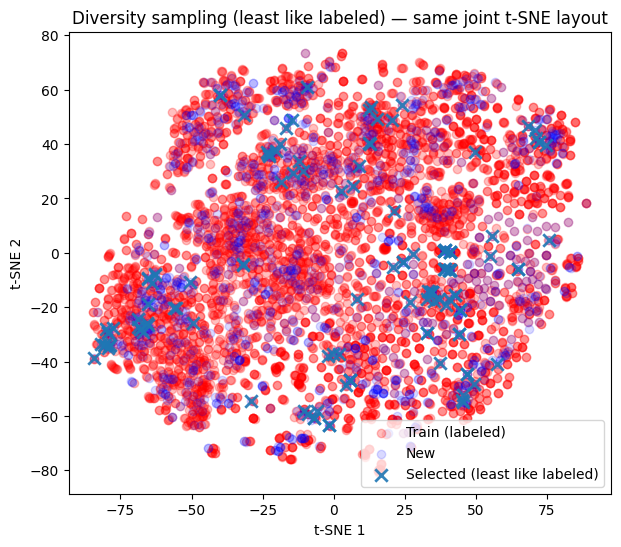

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# -------------------------------------------------------------------
# Diversity sampling: select points least like ALREADY LABELED points
# (Top-K farthest-from-labeled)
# -------------------------------------------------------------------

def farthest_from_labeled(X_new, X_labeled, k):
    """
    Select k samples from X_new that are least like already-labeled points.

    Criterion:
        score(x) = min_{z in labeled} ||x - z||
    Then select top-k by score.

    Args:
        X_new: (N_new, d) feature matrix of NEW / unlabeled data
        X_labeled: (N_lab, d) feature matrix of LABELED data
        k: number of samples to select from X_new

    Returns:
        selected_idx: list of indices (into X_new) of selected samples
        dist_to_labeled: (N_new,) distance to nearest labeled point (the diversity score)
    """
    # Distance from each new point to all labeled points
    D = pairwise_distances(X_new, X_labeled, metric="euclidean")  # (N_new, N_lab)

    # Diversity score = distance to the nearest labeled point
    dist_to_labeled = D.min(axis=1)  # (N_new,)

    # Select top-k points with largest distance to labeled set
    selected_idx = np.argsort(dist_to_labeled)[::-1][:k].tolist()

    return selected_idx, dist_to_labeled


# -----------------------
# Selection
# -----------------------

# X_labeled_embedded: embedding/features of LABELED train set (e.g., joint t-SNE coords)
# X_new_embedded:     embedding/features of NEW dataset (same space)

N = X_new_embedded.shape[0]
k = int(0.10 * N)
print("Selecting diverse samples:", k, "out of", N)

selected_diverse, dist_to_labeled = farthest_from_labeled(
    X_new=X_new_embedded,
    X_labeled=X_train_embedded,
    k=k
)

print("Diverse indices selected:", len(selected_diverse))
print("Diversity score stats (dist to nearest labeled): "
      f"mean={dist_to_labeled.mean():.3f}, min={dist_to_labeled.min():.3f}, max={dist_to_labeled.max():.3f}")

# -----------------------
# Visualization
# -----------------------
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(X_train_joint [:, 0], X_train_joint [:, 1], alpha=0.25, color='red', label="Train (labeled)")
ax.scatter(X_new_joint[:, 0], X_new_joint[:, 1], alpha=0.15, color='blue', label="New")
ax.scatter(X_new_joint[selected_diverse, 0],
           X_new_joint[selected_diverse, 1],
           marker="x", s=80, linewidths=2, alpha=0.9,
           label="Selected (least like labeled)")
ax.set_title("Diversity sampling (least like labeled) — same joint t-SNE layout")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.legend()
plt.show()
plt.close()
# selected_diverse are indices INTO new_dataset
# diverse_subset = torch.utils.data.Subset(new_dataset, selected_diverse)


Selelecting 10% diversity samples: data points that are least like already labeled points

#Whole Pipeline- Active Learning (Diversity Sampling):Retrain the model on 10% distance samples after labeling them

Find the comments "#Add your code"

In [ ]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import random
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed for reproducibility
set_seed(42)
#Set GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=5, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

def get_diversity_indices():
# 1. Load the NEW (Unlabeled) Dataset
    new_dataset_ = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]))

    # 2. Load the LABELED (Training) Dataset
    # We must load this to compare against!


    print(f'New samples: {len(new_dataset_)} | Labeled samples: {len(X_train)}')

    # 3. Flatten features for NEW dataset
    img_new_flat = []
    for data, _ in new_dataset_:
        # Taking 1st channel (approx grayscale) to match your previous logic
        img_new_flat.append(np.array(data)[0, :, :])
    X_new = np.array(img_new_flat).reshape(len(new_dataset_), -1)

    # 4. Flatten features for LABELED dataset
    # 5. Calculate Distances (Diversity Logic)
    # We calculate the distance from every new point to every labeled point
    print("Calculating distances...")
    # shape: (n_new_samples, n_labeled_samples)
    dists = pairwise_distances(X_new, X_train, metric='euclidean')

    # For each new point, find the distance to the NEAREST labeled point
    min_dist_to_labeled = dists.min(axis=1)

    # 6. Select Top 10% "Farthest" samples
    # We want points where the nearest neighbor is as far away as possible (high diversity)
    k = int(0.10 * len(new_dataset_))

    # argsort sorts ascending, so [::-1] reverses it to descending
    diversity_indices = np.argsort(min_dist_to_labeled)[::-1][:k].tolist()

    print(f"Selected {len(diversity_indices)} diverse samples.")
    return diversity_indices


if __name__ == '__main__':
    args = get_arguments()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

    # Prepare original dataset
    dataset_ = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    # Define split ratios
    train_ratio = 0.8
    val_ratio = 0.2

    # Calculate lengths for each split
    total_size = len(dataset_)
    train_size = int(total_size * train_ratio)
    val_size = total_size - train_size

    # Perform the split
    train_split, val_split = torch.utils.data.random_split(dataset_, [train_size, val_size])
    print('Training on:', device, 'train sample size:', len(train_split), 'valid sample size:', len(val_split))

    # Prepare new dataset
    new_dataset = datasets.ImageFolder(root='/content/braintumor_v2', transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

    # Get high uncertainity indices
    diversity_indices = get_diversity_indices()

    # Create a subset dataset with selected samples
    diversity_subset = torch.utils.data.Subset(new_dataset, diversity_indices)

    # Merge the subsets
    merged_dataset = ConcatDataset([diversity_subset, train_split])
    print('Training on:', device, 'merged train sample size:', len(merged_dataset), 'valid sample size:', len(val_split))

    # Prepare dataloader
    trainloader = DataLoader(merged_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(val_split, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    print(dataset_.class_to_idx)

    model = models.resnet34(weights=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth.tar')
        print('epoch: {}  acc: {:.3f}  best epoch: {}  best acc: {:.3f}'.format(
                epoch, accuracy*100, best_epoch, best_acc*100, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 4569 valid sample size: 1143
New samples: 1311 | Labeled samples: 4569
Calculating distances...
Selected 131 diverse samples.
Training on: cuda merged train sample size: 4700 valid sample size: 1143
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 0  acc: 97.025  best epoch: 0  best acc: 97.025
epoch: 1  acc: 98.513  best epoch: 1  best acc: 98.513
epoch: 2  acc: 98.338  best epoch: 1  best acc: 98.513
epoch: 3  acc: 97.550  best epoch: 1  best acc: 98.513
epoch: 4  acc: 98.600  best epoch: 4  best acc: 98.600
